# Week 9

This notebook covers three parts: an expansion on scikit-learn, Scipy for statistics, and Scipy for solving differential equations.

## 1. More on scikit-learn

We'll discuss another dimensionality reduction option - independent component analysis ([ICA](https://en.wikipedia.org/wiki/Independent_component_analysis)). It assumes that observed data is a sum of independent components, and then tries to learn how it is mixed to be able to un-mix the data into original sources. In practical terms, you can think of it as trying to separate multiple sound sources from a single microphone.

### Signal generation

First, let's generate some data:
> 1. Create time array: an array of 2000 elements ranging from 0 to 2. Let's say it represents 2 seconds. Hint: there is a useful Numpy function for that!
> 2. Create a sinusoidal signal with a frequency of 2 Hz and amplitude of 2 a.u. Hint: use [`np.sin()`](https://numpy.org/doc/stable/reference/generated/numpy.sin.html).
> 3. Create a second sinusoidal signal with a frequency of 5 Hz, amplitude of 0.5 a.u., and phase of 0.1.
> 4. Create any square signal using a combination of [`np.sign()`](https://numpy.org/doc/stable/reference/generated/numpy.sign.html) and a sinusoidal signal with a frequency of 3 Hz.
> 5. Check how all of these signals look like by plotting them in a single plot with three subplots.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# ! pip install matplotlib

In [17]:
time = np.linspace(0, 2, 2000)
signal_sin2 = 2 * np.sin(2 * np.pi * time)
signal_sin5 = 0.5 * np.sin(5 * np.pi * time + 0.1)
signal_square = np.sign(np.sin(3 * np.pi * time))

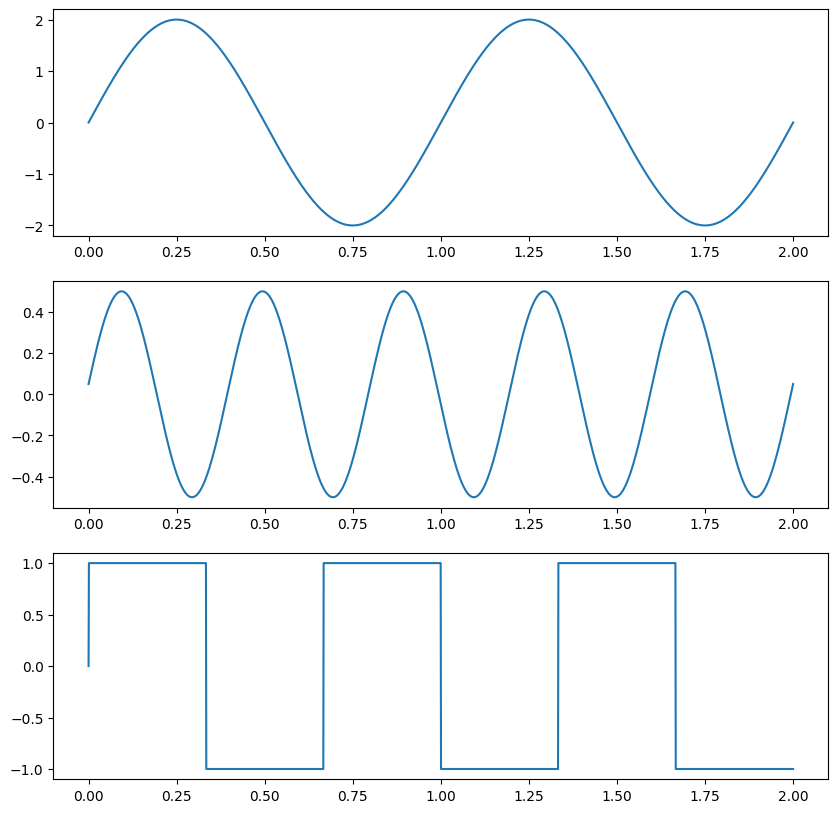

In [21]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
signals = [signal_sin2, signal_sin5, signal_square]

for ax, signal in zip(axs, signals):
    ax.plot(time, signal)
plt.show()
# axs[0].plot(time, signal_sin2)

Let's add some noise and mix these signals:

1. Join (stack) all three signals into a single array named `S`. Transform it so the shape is `(2000, 3)`.
1. Create a sequence of gaussian noise (random floats taken from [normal](https://numpy.org/doc/2.0/reference/random/generated/numpy.random.normal.html) distribution), scale it to be smaller than initial signals (e.g multiply by 0.1), and add it to `S` (perform addition operation).
1. Divide `S` by its standard deviation which should be calculated independently for each signal (so there should be 3 values).
1. The mixing matrix `A` is already defined in code cell. Use it to get our mixed signal `X` by multiplying `S` by `A`. Hint: use matrix multiplication instead of element-wise multiplication!

The mixing matrix `A` is what the model is trying to learn. This matrix tells you what the proportions of each original signal are, and thus can be used to recover original signals (separate them).

In [37]:
S = np.vstack(signals).T
noise = np.random.normal(size = S.shape) * 0.1
S += noise
S /= np.std(S, axis = 0)
S.shape

(2000, 3)

In [38]:
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]]).T
X = S @ A

Plot the mixed signals.

Try changing the mixing matrix. Can you make one of the mixed signals equal to one of the originals?

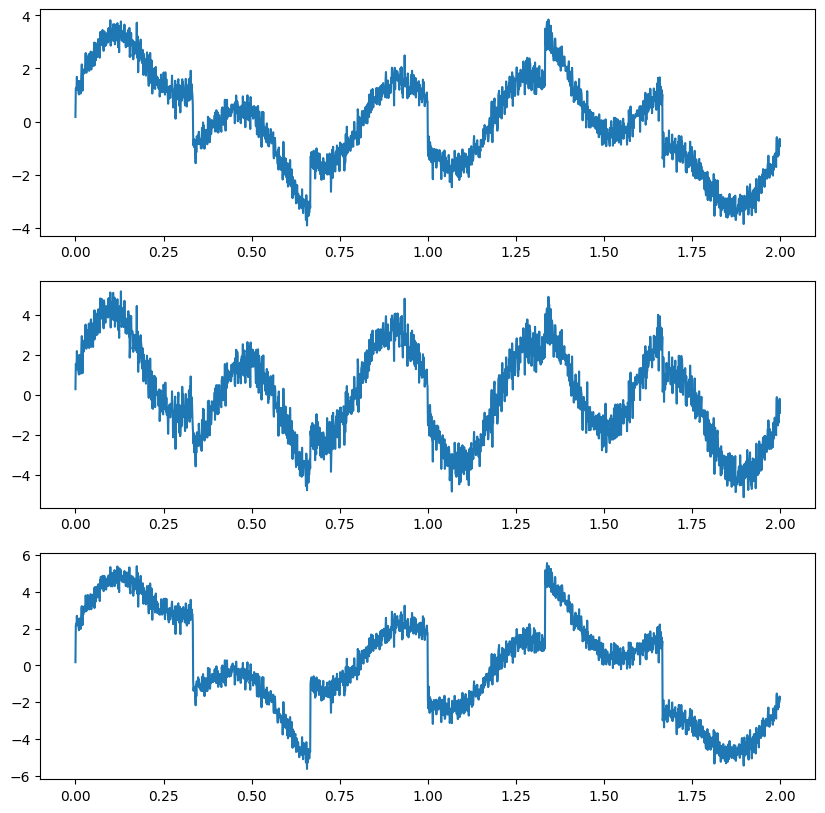

In [39]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for i, ax in enumerate(axs):
    ax.plot(time, X[:, i])

### ICA

Finally, it's time to try to recover our signals using ICA. In scikit-learn, it can be accessed as `FastICA`, and the estimated mixing matrix can be printed by `.mixing_` after fitting.
> 1. Create a `FastICA` object with `n_components=3`, as we are trying to recover three components.
> 2. Fit the ICA on `X`. Print the estimated mixing matrix. Is it similar to the original?
> 3. Transform the mixed signals to get the predicted original components, and plot them over the real original signals. How similar are the predicted signals to the original ones? Did their order change? Does it changes again if you rerun ICA again?

In [41]:
# !pip install scikit-learn
ica.mixing_

array([[-1.01739134, -0.9882441 ,  1.00333664],
       [-2.01820689, -0.96908927,  0.50525543],
       [-1.0358783 , -1.9905837 ,  1.50476911]])

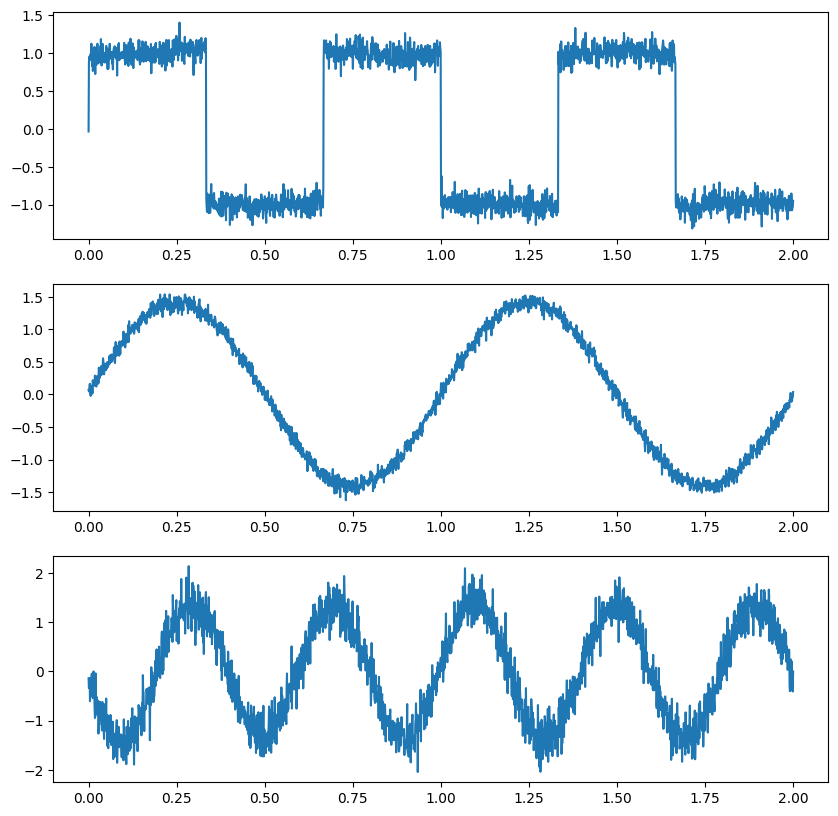

In [42]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components = 3)
ica.fit(X)
X_recovered = ica.transform(X)
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for i, ax in enumerate(axs):
    ax.plot(time, X_recovered[:, i])

## 2. Statistics with Scipy

Scipy stands for Scientific Python, which is quite self-explanatory. It extends Numpy to include more functions for scientific computing, including statistics, signal processing, image processing, integration, linear algebra and more. This makes it impossible to cover everything, but let's look at some specific examples.

## Stats

Most commonly used statistical tests are available in `scipy.stats`. Let's import some data and run some statistical tests.

- If you don't have kagglehub and don't want to install it, use this link: https://www.kaggle.com/api/v1/datasets/download/uciml/biomechanical-features-of-orthopedic-patients?dataset_version_number=1

In [44]:
import os, kagglehub

path = kagglehub.dataset_download("uciml/biomechanical-features-of-orthopedic-patients")
data_files = os.listdir(path)
print('Downloaded files:', data_files)

100%|█████████████████████████████████████████████████████████████████████████████| 23.2k/23.2k [00:00<00:00, 15.4MB/s]

Extracting model files...
Downloaded files: ['column_2C_weka.csv', 'column_3C_weka.csv']


> Load and explore the first file (2C) using pandas. You can get the path using `os.path.join(path, data_files[0])`.

This should be a standard procedure for any datafiles: check its data types and basic statistics with two relevant Pandas functions.

In [45]:
import pandas as pd
file_path = os.path.join(path, data_files[0])
df = pd.read_csv(file_path)
df.head()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


In [46]:
df.describe()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


In [47]:
df.size

2170

In [49]:
!pip install seaborn

We have a `class` column, which we will use for **getting data groups**.
> Use the seaborn pairplot to plot all features. Set the hue parameter to `class` to have differently colored groups.

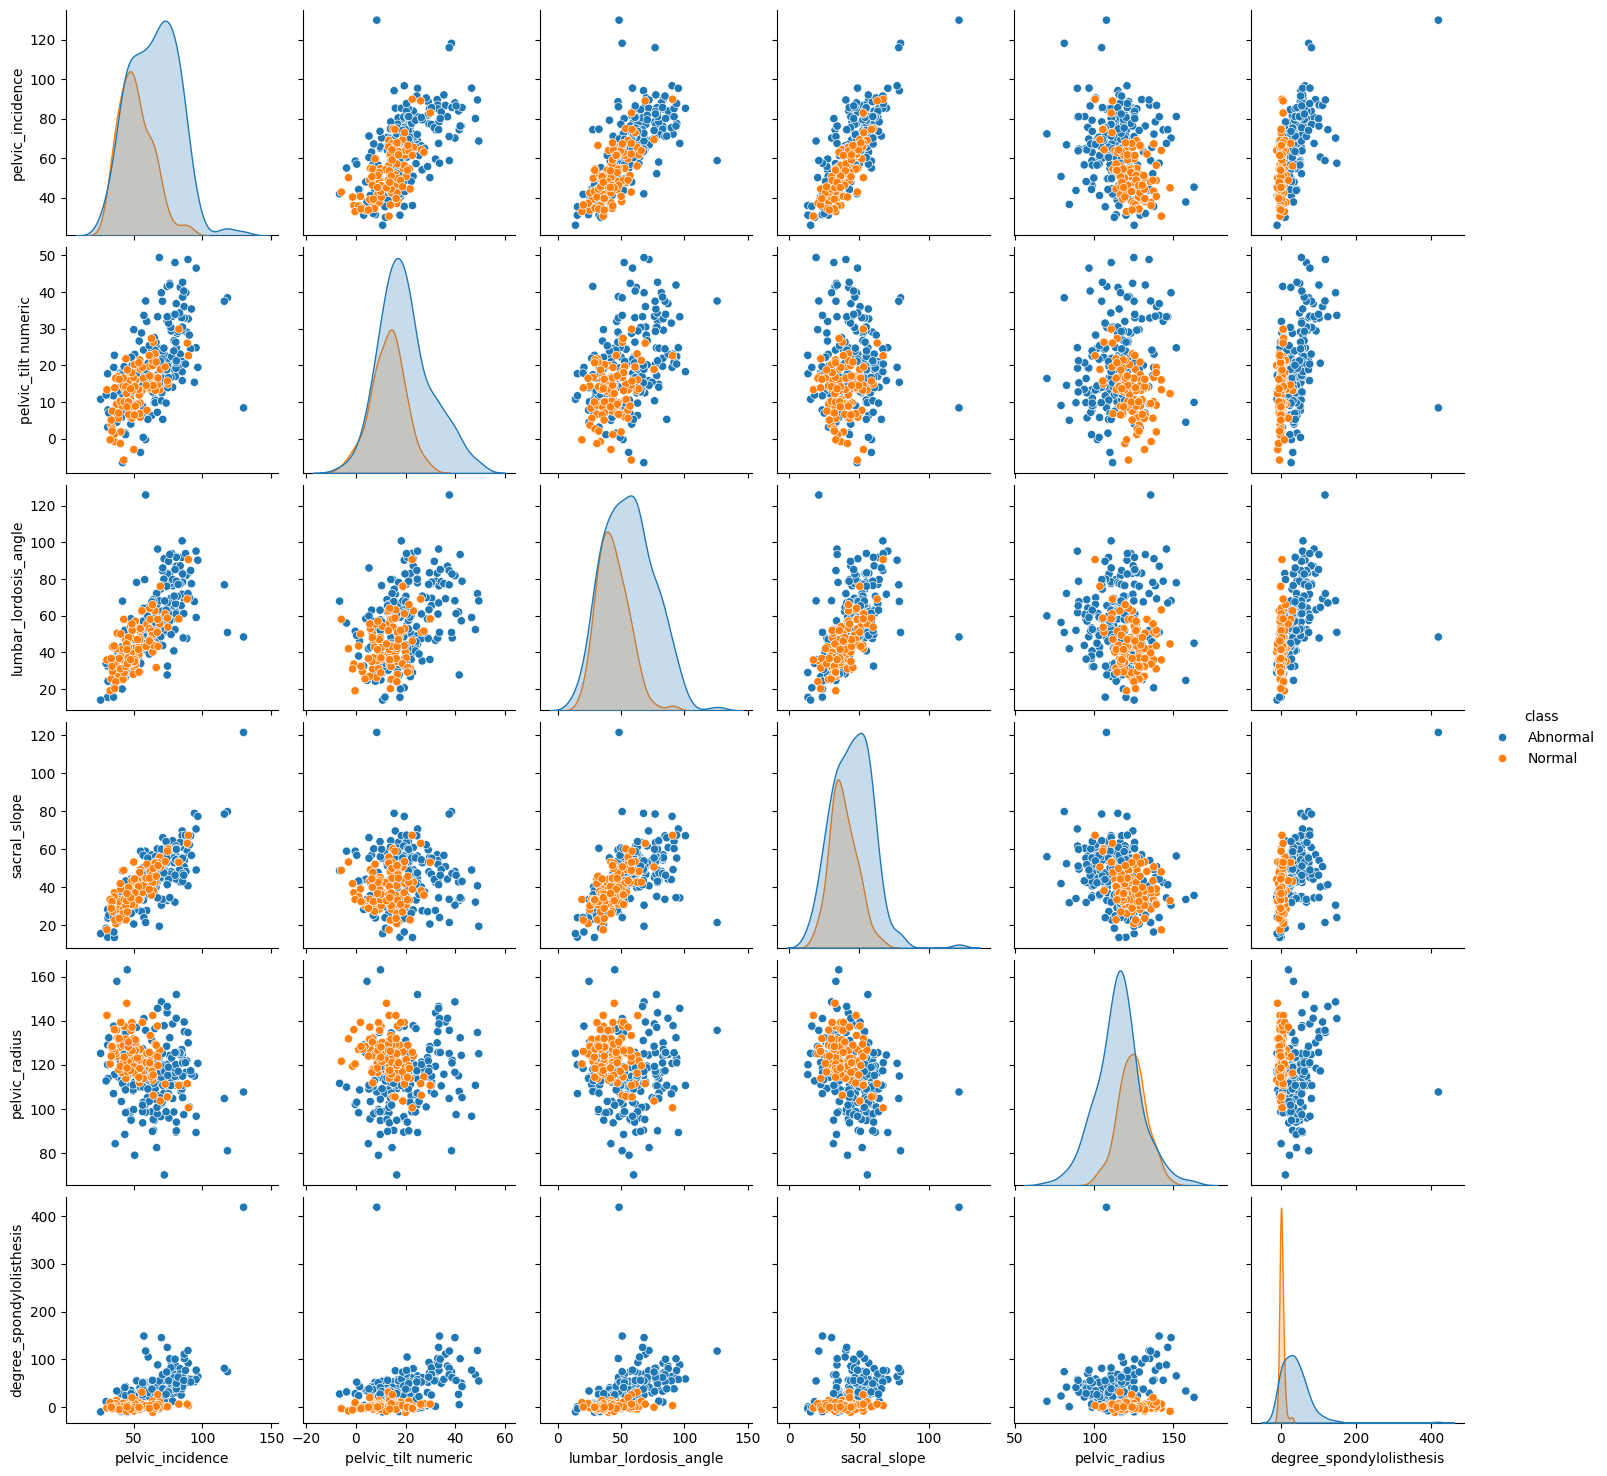

In [50]:
import seaborn as sns
sns.pairplot(df, hue = 'class')

> Separate `df` into two groups: one group has only `class=0`, while another only has `class=1`.

In [52]:
classes = df['class'].unique()

In [54]:
group0 = df.loc[df['class'] == classes[0], 'lumbar_lordosis_angle']
group1 = df.loc[df['class'] == classes[1], 'lumbar_lordosis_angle']

At first sight, there does seem to be some difference between groups.

Let's compare the lumbar lordosis angle between the groups. First, we need to check whether the data is normally distributed, because that would mean we can use parametric statistical methods.
> Use the [`normaltest()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html) function from Scipy to check whether the distribution of lumbar lordosis angle is normal in each group.  

- As written on Scipy page: the `normaltest()` function tests the null hypothesis that a sample comes from a normal distribution. If the p-value is “small”, this may be taken as evidence against the null hypothesis, meaning that the values were not drawn from a normal distribution. Hovewer, keep in mind that the inverse is not true; that is, the test is not used to provide evidence for the null hypothesis.

NormaltestResult(statistic=3.678139703087747, pvalue=0.15896521861445084)
NormaltestResult(statistic=12.70738696242387, pvalue=0.001740307458266912)


(array([ 5., 15., 24., 22., 16., 10.,  6.,  1.,  0.,  1.]),
 array([19.0710746 , 26.22031328, 33.36955197, 40.51879065, 47.66802934,
        54.81726802, 61.9665067 , 69.11574539, 76.26498407, 83.41422276,
        90.56346144]),
 <BarContainer object of 10 artists>)

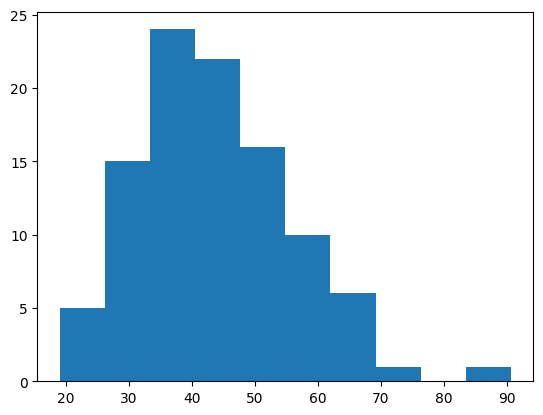

In [58]:
from scipy import stats
print(stats.normaltest(group0))
print(stats.normaltest(group1))
plt.hist(group1)

Since one of the distributions is not normal, a non-parametric test is more suitable in this case. An alternative of the independent sample t-test is the Mann-Whitney U test.
> Separate groups into two
> Perform the Mann-Whitney U test by using [`mannwhitneyu()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html). Is there a significant difference between groups?

In [62]:
alpha = 0.05
if stats.mannwhitneyu(group0, group1)[1] < alpha:
    print('statistically significant!')

statistically significant!


## 3. Integration with Scipy

Sometimes, we're interested how things change in time. This is described by differential equations. For example, how a population changes can be approximated as:

$dP/dt = kP(1-P/L)$,

- $P$: Population size
- $L$: Limiting capacity (how many resources are available, ~ max population)
- $k$: Constant of proportionality (birth rate/death rate)

This is an example of an ordinary differential equation, which depends only on a single independent variable. Some of them have defined mathematical solutions, and others can have multiple or none, but finding out those solutions can be time-consuming, and thus done automatically.

In Scipy, it can be done by using the [`odeint()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) function. This function requires the time series, initial condition, $dy/dt$ function, and any optional arguments. Let's calculate it for the population equation.

> 1. Write the population equation as a function `population_eq()`. It should take `P`, `t`, `k` and `L` as parameters, and return the `dpdt` expression.
> 2. Create 1000 time points from 0 to 100. Set the initial conditions: `P0 = 200`, `k = 0.5`, `L = 100`.
> 3. Solve the equation using `scipy.odeint(population_eq, P0, t, args=())`.
> 4. Plot the solution.

Play around with initial parameters. Can you get to a stable population size?

In [64]:
def pop_eq(P, t, k, L):
  dpdt = k * P * (1 - P/L)
  return dpdt

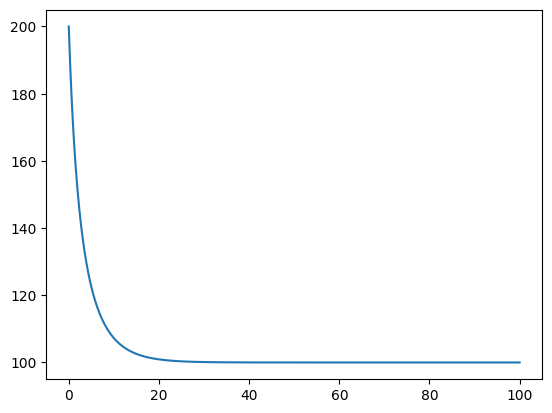

In [68]:
from scipy import integrate


time = np.linspace(0, 100, 1000)
P0 = 200
k = 0.2
L = 100

solution = integrate.odeint(pop_eq, P0, time, args = (k, L))

plt.plot(time, solution)